In [1]:
# Required to install packages
!pip install medpy
!pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 21.0 MB/s 
     |████████████████████████████████| 52.7 MB 91 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754452 sha256=6bc11fa80519356d6f1e1a7f6dccf9c55057f11e96102be15ef0da8accd559c5
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 


## Import libraries

In [2]:
import os
import numpy as np
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Cursor
import skimage.io as io
from math import ceil
import glob
import tensorflow as tf
import keras
from keras.models import load_model
import shutil

## Import your data

To import data from kaggle using API you should have an account
Upload kaggle.json to your Colab project: for instance, you can import `files` module from `google.colab`, and call `upload()` to launch a File Upload dialog and select the kaggle.json from your local machine.

In [3]:
from google.colab import files
API_key = files.upload()

Saving kaggle.json to kaggle.json


Update `KAGGLE_CONFIG_DIR` path to the current working directory. You can run `!pwd` to get the current working directory and assign the value to `os.environ['KAGGLE_CONFIG_DIR']` :

In [4]:
!rm -r sample_data

In [ ]:
!pwd

/content


In [5]:
import os
current_dir = os.popen('pwd').read().strip()
os.environ['KAGGLE_CONFIG_DIR'] = current_dir

In [6]:
# Download dataset

#!chmod 600 /content/kaggle.json # uncomment to set API key to unreadable
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [03:26<00:00, 19.7MB/s]
100% 4.16G/4.16G [03:26<00:00, 21.6MB/s]


In [7]:
# Unizp imported dateset
!unzip -q brats20-dataset-training-validation.zip # -q or &> /dev/null to not prompt the output

In [8]:
!rm brats20-dataset-training-validation.zip

In [50]:
!rm -r /content/BraTS2020_ValidationData

In [9]:
# Rename a specific file with a typo in the 355 patient folder (TrainingData, patient 355, segmentation file)
os.rename("/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii",
          "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii")

## **Loading/Visualizing our data**

#### To begin with let's get familiar with the data we are working with :

* The features (inputs)

    *  Brain scans (IRMs) are generally made of 4 sequences (Flair, T1, T1CE, T2).
        - **Flair** : Fluid Attenuated Inversion Recovery
        - **T1** : bla
        - **T1CE** : bla
        - **T2** : bla
    * Each chanel being a 3D image (X, Y, Z). A 3D image of a brain is commonly called a voxel.

* The labels (outputs)

    * 3D images called masks, that represents the tumor in a brain.
    * The integer values in this array indicate the "classified label" for each voxel in the corresponding image files:

        - 0: background
        - 1: edema
        - 2: non-enhancing tumor
        - 3: N/A
        - 4: enhancing tumor
    * Replace label 4 by 3 because 3 by default is empty in the processing step.

#### Loading an image into an array

In [20]:
def load(filepath):
	"""
	Load a brain IRM with either of those extensions (.mha, .nii, .nii.gz, .npy)
	"""
	
	file_ext = filepath.split('.')[-1]
	name = filepath.split('.')[-2].split('/')[-1]
	
	# Load inputs data
	if file_ext == 'mha':
		image_data, image_header = medpy.io.load(filepath)
	elif file_ext == 'nii' or 'nii' + file_ext == 'niigz':
		image_data = nib.load(filepath).get_fdata()
	elif file_ext == 'npy':
		image_data = np.load("filename")
	else:
		print("Make sure to enter a supported file extension (.mha / .nii / .nii.gz / .npy)")
		return -1

	print("File information:")
	print("\t Input file name: {}".format(name))
	print("\t Input file type: {}".format(file_ext))
	print("\t Shape: {}".format(image_data.shape))

	print("----------------------------------------------------------------")
	return np.array(image_data)

#### Simple 2D plotting

In [32]:
def display2D(brain_data, seg_data=None, brain_color_map='bone', seg_color_map='jet'):

	if len(brain_data) < 0:
		# Return value of loadign image < -1 -> error occurred
		return -1
	if brain_data.ndim != 3:
		print("You should provide a 3 dimension array as brain data")
		return -1

	print("Type of brain data {}".format(type(brain_data)))

	if seg_data is not None:
		if len(seg_data) < 0:
			return -1
		if seg_data.ndim != 3:
			print("You should provide a 3 dimension array as seg data")
			return -1
		if brain_data.shape != seg_data.shape:
			print("Image data and Segmentation data do not have the same shape {}!={}".format(brain_data.shape, seg_data.shape))
			return -1

	print("Type of seg data {}".format(type(seg_data)))
	print("Brain and Segmentation data have shape {}".format(brain_data.shape))
        
	fig, ax = plt.subplots(1, 2)
        
    
	cut = random.randint(0, 2)

	if cut == 0:
		index = random.randint(0, brain_data.shape[cut]-1)
		if seg_data is not None:
			ax[0].set_title("YZ cut | layer: {}".format(index))
			ax[1].set_title("Segmentation/Mask")
			ax[0].imshow(brain_data[index, :, :], cmap=brain_color_map)
			ax[1].imshow(seg_data[index, :, :], cmap=seg_color_map)
		else:
			plt.title("YZ cut | layer: {}".format(index))
			plt.imshow(brain_data[index, :, :], cmap=brain_color_map)

	elif cut == 1:
		index = random.randint(0, brain_data.shape[cut]-1)
		if seg_data is not None:
			ax[0].set_title("XZ cut | layer: {}".format(index))
			ax[1].set_title("Segmentation/Mask")
			ax[0].imshow(brain_data[:, index, :], cmap=brain_color_map)
			ax[1].imshow(seg_data[:, index, :], cmap=seg_color_map)
		else:
			plt.title("XZ cut | layer: {}".format(index))
			plt.imshow(brain_data[:, index, :], cmap=brain_color_map)

	elif cut == 2:
		index = random.randint(0, brain_data.shape[cut]-1)
		if seg_data is not None:
			ax[0].set_title("XY cut | layer: {}".format(index))
			ax[1].set_title("Segmentation/Mask")
			ax[0].imshow(brain_data[:, :, index], cmap=brain_color_map)
			ax[1].imshow(seg_data[:, :, index], cmap=seg_color_map)
		else:
			plt.title("XY cut | layer: {}".format(index))
			plt.imshow(brain_data[:, :, index], cmap=brain_color_map)

File information:
	 Input file name: BraTS20_Training_001_t1ce
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_001_seg
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
Type of brain data <class 'numpy.ndarray'>
Type of seg data <class 'numpy.ndarray'>
Brain and Segmentation data have shape (240, 240, 155)


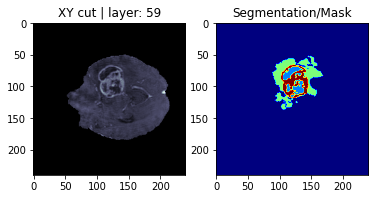

In [38]:
PATIENT = "001"
SEQUENCE = "t1ce"
image_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}_{}.nii".format(PATIENT, PATIENT, SEQUENCE)
seg_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}_seg.nii".format(PATIENT, PATIENT)
image_data = load(image_path)
seg_data = load(seg_path)
display2D(image_data, seg_data)

### Full 3D IRM display of a brain

To get a better overall view of the brain we should implement a function that gives us the posibility to look at every slice of the brain from any cut (angle) given.

In medical terms:
* Horizontal Cut (XY)
* Coronal Cut (XZ)
* Sagittal Cut (YZ)

>  **⚠️ Input shape should be (X, Y, Z)** (chose between flair, t1, t1ce and t2 for image_filename, and segmentation (seg) for seg_filename)

To be implemented -> interactive choice of chanel



In [40]:
def display3DCuts(brain_data, seg_data=None, brain_color_map='bone', seg_color_map='jet', seg_alpha=0.5):

	if len(brain_data) < 0:
		print("Brain data is empty")
		return -1
	if brain_data.ndim != 3:
		print("You should provide a 3 dimension array as brain data")
		return -1

	print("Type of brain data {}".format(type(brain_data)))

	if seg_data is not None:
		if len(seg_data) < 0:
			print("Segmentation data is empty")
			return -1
		if seg_data.ndim != 3:
			print("You should provide a 3 dimension array as seg data")
		if brain_data.shape != seg_data.shape:
			print("Image data and Segmentation data do not have the same shape {}!={}".format(brain_data.shape, seg_data.shape))
			return -1

	print("Type of seg data {}".format(type(seg_data)))
	print("Brain and Segmentation data have shape {}".format(brain_data.shape))

	# Plot with 3 Columns
	fig, ax = plt.subplots(1, 3)
	plt.subplots_adjust(bottom=0.25)

	# Create layers to place widgets
	axlayer_X = plt.axes([0.25, 0.2, 0.30, 0.03])
	axlayer_Y = plt.axes([0.25, 0.15, 0.30, 0.03])
	axlayer_Z = plt.axes([0.25, 0.1, 0.30, 0.03])

	# Get aprox the middle images for each of X Y Z
	half_X = ceil((brain_data.shape[0] - 1)/2)
	half_Y = ceil((brain_data.shape[1] - 1)/2)
	half_Z = ceil((brain_data.shape[2] - 1)/2)

	# Create Slider for each cut
	slider_X = Slider(axlayer_X, "Sagittal Cut", 0, brain_data.shape[0] - 1, valinit=half_X, valstep=1)
	slider_Y = Slider(axlayer_Y, "Coronal Cut", 0, brain_data.shape[1] - 1, valinit=half_Y, valstep=1)
	slider_Z = Slider(axlayer_Z, "Horizontal Cut", 0, brain_data.shape[2] - 1, valinit=half_Z, valstep=1)

	# Set title for each ax
	ax[0].set_title("{}/{}".format(half_X, brain_data.shape[0] - 1))
	ax[1].set_title("{}/{}".format(half_Y, brain_data.shape[1] - 1))
	ax[2].set_title("{}/{}".format(half_Z, brain_data.shape[2] - 1))

	# Update function for each respective slider and it's plot
	def update_X(val):
		layer = slider_X.val
		ax[0].imshow(brain_data[layer,:,:], cmap=brain_color_map)
		if seg_data is not None:
			ax[0].imshow(seg_data[layer,:,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[layer,:,:]>0))
		ax[0].set_title("{}/{}".format(layer, brain_data.shape[0] - 1))
		fig.canvas.draw_idle()

	def update_Y(val):
		layer = slider_Y.val
		ax[1].imshow(brain_data[:,layer,:], cmap=brain_color_map)
		if seg_data is not None:
			ax[1].imshow(seg_data[:,layer,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,layer,:]>0))
		ax[1].set_title("{}/{}".format(layer, brain_data.shape[1] - 1))
		fig.canvas.draw_idle()

	def update_Z(val):
		layer = slider_Z.val
		ax[2].imshow(brain_data[:,:,layer], cmap=brain_color_map)
		if seg_data is not None:
			ax[2].imshow(seg_data[:,:,layer], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,:,layer]>0))
		ax[2].set_title("{}/{}".format(layer, brain_data.shape[2] - 1))
		fig.canvas.draw_idle()


	# Update plot when interaction detected on slider
	slider_X.on_changed(update_X)
	slider_Y.on_changed(update_Y)
	slider_Z.on_changed(update_Z)
	

	# First display
	ax[0].imshow(brain_data[half_X,:,:], cmap=brain_color_map)
	ax[1].imshow(brain_data[:,half_Y,:], cmap=brain_color_map)
	ax[2].imshow(brain_data[:,:,half_Z], cmap=brain_color_map)
	if seg_data is not None:
		ax[0].imshow(seg_data[half_X,:,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[half_X,:,:]>0), vmin = 0)
		ax[1].imshow(seg_data[:,half_Y,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,half_Y,:]>0), vmin = 0)
		ax[2].imshow(seg_data[:,:,half_Z], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,:,half_Z]>0), vmin = 0)


	# Turn off all of the axis
	ax[0].axis('off')
	ax[1].axis('off')
	ax[2].axis('off')

	# Show plot
	plt.show()

Type of brain data <class 'numpy.ndarray'>
Type of seg data <class 'numpy.ndarray'>
Brain and Segmentation data have shape (240, 240, 155)


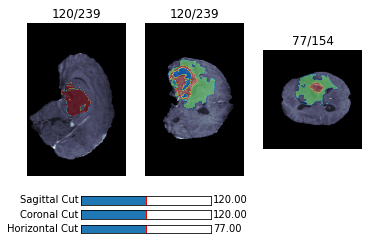

In [42]:
display3DCuts(image_data, seg_data) # Due to colab not being interactive with matplotlib interactive ploting not working for the moment

## Data processing

* Rescale the data we are working with

* Lots of infromation are not helpful and can lead to biases in our neural networks.

    * The data given contains 4 sequence as mentionned above. Knowing that the T1ce is a contrast-enhanced version of the T1 we can get rid of the T1 sequence.
    * Empty (black) portions of the scans : reduce the shape of the data from 255x255x155 to 128x128x128 to "crop" the images taking out all the blanc usless information (less computing time + less bias for the Neural Network).

* Input shape of the model
    * S being the number of sequences: (X, Y, Z, S) -> (128, 128, 128, 3)

* Output shape of the model
    * (X, Y, Z) -> (128, 128, 128) 

In [43]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

# Init a MinMaxScaler
scaler = MinMaxScaler()

### Process feature images (Brain)

Four step process:
* Scale each eequence array
* Combine 3 of the 4 sequence given (Flair, T1CE and T2) into one array
* Reshape/Crop it 
* Save it as a numpy array (`.npy`)

Getting a final result of a (128, 128, 128, 3) array  

In [62]:
def process_images(patient_dir_path, processed_dir_path="", file_ext='nii'):

	patient = patient_dir_path.split('/')[-1]

	image_flair = load(os.path.join(patient_dir_path, "{}_flair.{}".format(patient, file_ext)))
	image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

	"""
	# Not useful
	test_image_t1 = load(os.path.join(patient_dir_path, "{}_t1.{}".format(patient, file_ext)))
	test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
	"""

	image_t1ce = load(os.path.join(patient_dir_path, "{}_t1ce.{}".format(patient, file_ext)))
	image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

	image_t2 = load(os.path.join(patient_dir_path, "{}_t2.{}".format(patient, file_ext)))
	image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

	if image_flair.shape == image_t1ce.shape == image_t2.shape and image_flair.ndim == image_t1ce.ndim == image_t2.ndim == 3 :
		# Stack 3 most important channel into 1 numpy array to feed the U-Net
		resulting_image = np.stack([image_flair,
									image_t1ce,
									image_t2], axis=3)

		# Crop the image from 240x240x155 to 128x128x128
		resulting_image = resulting_image[56:184, 56:184, 13:141] # Shape 128x128x128x3 (x4 if t1 included)

		np.save(os.path.join(processed_dir_path, "images", patient+".npy"), resulting_image)
		
	else:
		print("Channels don't have the same shape and/or are not conform to the standard IRM dim (X, X, X) for each channel")
		return -1

### Process label images (Mask)

In [63]:
def process_mask(patient_dir_path, processed_dir_path="", file_ext='nii'):

	patient = patient_dir_path.split('/')[-1]

	mask = load(os.path.join(patient_dir_path, "{}_seg.{}".format(patient, file_ext)))
	mask = mask.astype(np.uint8)

	mask[mask==4] = 3 
	mask = mask[56:184, 56:184, 13:141] # Shape 128x128x128

	mask = to_categorical(mask, num_classes=4)
	np.save(os.path.join(processed_dir_path, "mask", patient+".npy"), mask)


### Process patient

In [48]:
def process_patient(patient_dir_path, processed_path="", val=False):
    """
    Processes the images and the mask of a single patient by calling above functions
    """
    if val:
        process_mask(patient_dir_path, processed_path)
        process_images(patient_dir_path, processed_path)
        return True
    else:
        if random.randint(0,10) <= 8: # Get a ~80% chance of getting picked for training
            process_mask(patient_dir_path, processed_path)
            process_images(patient_dir_path, processed_path)
            return True
        return False

### Process dataset

In [59]:
def process_dataset(dataset_path=None, processed_path="", val=False):
    """
    Process an entire dataset with a specific schema
    """
    
    if dataset_path is None:
        print("Please enter a dataset path")
        return -1

    # Create the folders in which fill the processed images following schema:
    """ training_processed/
    ├─ images/
    │  ├─ BraTS20_Training_001.npy
    │  ├─ BraTS20_Training_002.npy
    │  ├─ BraTS20_Training_XXX.npy
    │  ├─ BraTS20_Training_YYY.npy
    ├─ mask/
    │  ├─ BraTS20_Training_001.npy
    │  ├─ BraTS20_Training_002.npy
    │  ├─ BraTS20_Training_XXX.npy
    │  ├─ BraTS20_Training_YYY.npy
    """
    #os.mkdir(processed_path)
    os.mkdir(processed_path+"/images")
    os.mkdir(processed_path+"/mask")

    # Processes each patient in the original dataset
    for dirname, patients, filenames in os.walk(dataset_path):
        for patient in patients: 
            if process_patient(os.path.join(dirname, patient), processed_path, val):
                shutil.rmtree(os.path.join(dirname, patient))

In [54]:
!mkdir BraTS2020_ProcessedData

In [55]:
!mkdir BraTS2020_ProcessedData/train

In [56]:
!mkdir BraTS2020_ProcessedData/val

In [64]:
process_dataset("/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData", "/content/BraTS2020_ProcessedData/train")

Streaming output truncated to the last 5000 lines.
File information:
	 Input file name: BraTS20_Training_165_seg
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_165_flair
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_165_t1ce
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_165_t2
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_100_seg
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_100_flair
	 Input 

In [65]:
# !! Run the upper cell before !!
process_dataset("/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/", "/content/BraTS2020_ProcessedData/val", True)

File information:
	 Input file name: BraTS20_Training_233_seg
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_233_flair
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_233_t1ce
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_233_t2
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_063_seg
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_063_flair
	 Input file type: nii
	 Shape: (240, 240, 155)
-----------

### DataGen

IRMs are medical images, being too big, let's generate batches of them to feed our NN.

In [66]:
def loadImageBis(image_dir, image_list):
    """
    Load images in a given directory for a given list
    """

    images = []
    
    for i, image_name in enumerate(image_list):
        if (image_name.split(".")[-1] == 'npy'):
            image = np.load(image_dir + image_name)
            images.append(image)
    
    images = np.array(images)
    
    return images


In [67]:
def imageLoader(image_dir, image_list, mask_dir, mask_list, batch_size):
    
    L = len(image_list) 

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)


            X = loadImageBis(image_dir, image_list[batch_start:limit])
            Y = loadImageBis(mask_dir, mask_list[batch_start:limit])

            yield(X, Y)

            batch_start += batch_size
            batch_end += batch_size

## Model

Our model will be based on the U-Net shape 

In [68]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' # the way we initialize our weights


def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    
    return model

In [69]:
train_img_dir = "/content/BraTS2020_ProcessedData/train/images/"
train_mask_dir = "/content/BraTS2020_ProcessedData/train/mask/"

val_img_dir = "/content/BraTS2020_ProcessedData/val/images/"
val_mask_dir = "/content/BraTS2020_ProcessedData/val/mask/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


In [70]:
!mkdir saved_models

In [73]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)



metrics = [sm.metrics.FScore(), sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= "/content/saved_models/brats_3d_simple_unet_{epoch:02d}.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

tb_callback = tf.keras.callbacks.TensorBoard('logs')

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics) # Adding metrics to replace accuracy (Wrong interpretation)

print(model.summary())
print(model.input_shape)
print(model.output_shape)


history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[cp_callback, tb_callback]
          )


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_12 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_6 (Dropout)            (None, 128, 128, 12  0           ['conv3d_12[0][0]']              
                                8, 16)                                                        

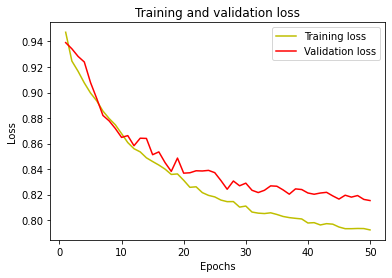

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

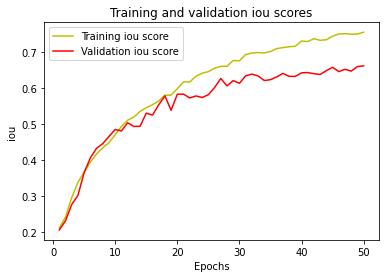

In [75]:
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training iou score')
plt.plot(epochs, val_iou, 'r', label='Validation iou score')
plt.title('Training and validation iou scores')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

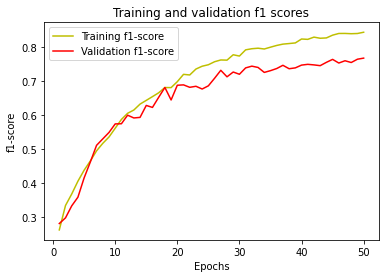

In [76]:
f_score = history.history['f1-score']
val_f_score = history.history['val_f1-score']

plt.plot(epochs, f_score, 'y', label='Training f1-score')
plt.plot(epochs, val_f_score, 'r', label='Validation f1-score')
plt.title('Training and validation f1 scores')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

1/1 [==============================] - 0s 289ms/step


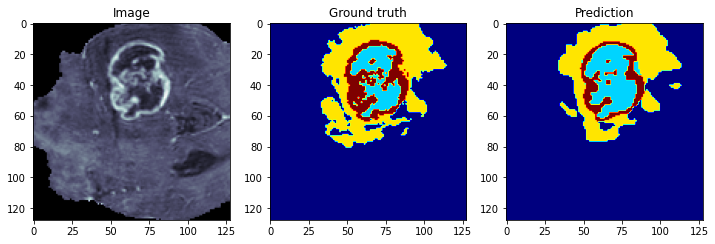

In [87]:

img_num = "001"

test_img = np.load("/content/BraTS2020_ProcessedData/val/images/BraTS20_Training_"+str(img_num)+".npy")

test_mask = np.load("/content/BraTS2020_ProcessedData/val/mask/BraTS20_Training_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)

my_model = load_model('/content/saved_models/brats_3d_simple_unet_50.h5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                      'f1-score':sm.metrics.FScore()})

test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='bone')
plt.subplot(232)
plt.title('Ground truth')
plt.imshow(test_mask_argmax[:,:,n_slice], cmap='jet')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(test_prediction_argmax[:,:, n_slice], cmap='jet')
plt.show()